In [ ]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qa_qc_lib.qa_qc_seismic import *

In [ ]:
def generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length):
    if num_sides < 3:
        raise ValueError("A polygon must have at least 3 sides.")

    # Generate random side lengths
    side_lengths = np.random.uniform(min_side_length, max_side_length, num_sides)

    # Calculate the total perimeter of the polygon
    total_perimeter = np.sum(side_lengths)

    # Calculate the angles between the sides
    angles = np.random.uniform(0, 360, num_sides)

    # Generate the cumulative angles for vertex positions
    cumulative_angles = np.cumsum(angles)

    # Generate the coordinates of the polygon vertices
    x_coords = total_perimeter * np.cos(np.radians(cumulative_angles))
    y_coords = total_perimeter * np.sin(np.radians(cumulative_angles))

    # Close the polygon
    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    # Check if any of the sides intersect, and if so, regenerate the polygon
    for i in range(num_sides):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % num_sides], y_coords[(i + 1) % num_sides]
        for j in range(i + 2, num_sides):
            x3, y3 = x_coords[j], y_coords[j]
            x4, y4 = x_coords[(j + 1) % num_sides], y_coords[(j + 1) % num_sides]
            if do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
                return generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

    return x_coords, y_coords

def do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
    # Check if two line segments intersect using the cross product method
    def cross_product(x1, y1, x2, y2):
        return x1 * y2 - x2 * y1

    d1 = cross_product(x4 - x3, y4 - y3, x1 - x3, y1 - y3)
    d2 = cross_product(x4 - x3, y4 - y3, x2 - x3, y2 - y3)
    d3 = cross_product(x2 - x1, y2 - y1, x3 - x1, y3 - y1)
    d4 = cross_product(x2 - x1, y2 - y1, x4 - x1, y4 - y1)

    if (d1 * d2 < 0) and (d3 * d4 < 0):
        return True
    return False


def add_noise_to_polygon(polygon_points, noise_factor=0.1):
    x_coords, y_coords = zip(*polygon_points)
    noise_x = np.random.uniform(-noise_factor, noise_factor, len(x_coords))
    noise_y = np.random.uniform(-noise_factor, noise_factor, len(y_coords))

    x_coords_noisy = [x + noise for x, noise in zip(x_coords, noise_x)]
    y_coords_noisy = [y + noise for y, noise in zip(y_coords, noise_y)]

    return list(zip(x_coords_noisy, y_coords_noisy))
    

def build_polygon_from_points(x_coords, y_coords):
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    rectangle_points = [(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)]
    return rectangle_points

In [ ]:

# Example usage:
num_sides = 5
min_side_length = 1
max_side_length = 5
x_coords, y_coords = generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

license_area_poly = list(zip(x_coords*5000, y_coords*500))
license_area_poly

In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt

def get_seismic_grid(segy_file_path: str):
    """Метод предназначенный для чтения сейсмического куба из файла формата SEG-Y 

    Args:
        segy_file_path (str): Путь к файлу с сейсмическими данными

    Returns:
        _type_: (куб сейсмических трасс, вектор координат X каждой из трасс, вектор координат Y каждой из трасс, вектор глубин)
    """
    segy = segyio.open(segy_file_path, 'r', strict=False)  # Открываем SEGY-файл в режиме чтения
    coordinate_x = segy.attributes(segyio.TraceField.SourceX)
    coordinate_y = segy.attributes(segyio.TraceField.SourceY)
    coordinate_z = segy.samples
    seismic_data = segyio.tools.cube(segy)
    return seismic_data, np.array(coordinate_x), np.array(coordinate_y), coordinate_z, segy


In [86]:
file_path = 'data/Глубинный куб NP cropped'

#file_path = 'data/Временной куб NP cropped'

seismic_cube, coordinate_x, coordinate_y, coordinate_z, segy = get_seismic_grid(file_path)


In [103]:
False and False

False

In [91]:
ilines, segy.ilines 

(array([   0,    1,    2, ..., 1523, 1524, 1525], dtype=int32),
 array([  50,   51,   52, ..., 1573, 1574, 1575], dtype=int32))

In [87]:
ilines = segy.ilines.copy()
ilines -= ilines[0]

xlines = segy.xlines.copy()
xlines -= xlines[0] 

# Создаём маску для отсечения отсутствующих сейсмотрасс
seismic_cube_r = seismic_cube.reshape(-1, seismic_cube.shape[2])
mask = np.all(seismic_cube_r == 0, axis=1)
mask = mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1]))

# Рассчитываем среднее значение и стандартное отклонение для всего куба
mean_val = np.mean(seismic_cube[~mask])
std_val = np.std(seismic_cube[~mask])

# Получаем сейсмотрассы на пересечении ilines и xlines
seismic_cube_r = seismic_cube.copy()
seismic_cube_r[mask] = mean_val
cross_section = seismic_cube_r[np.ix_(ilines, xlines)]

# Задаем порог для определения аномалий, 3 стандартных отклонения
threshold = 3.0

# Находим индексы аномальных значений в срезе
anomalies = np.where((cross_section > mean_val + threshold * std_val)| 
                     (cross_section < mean_val - threshold * std_val))

# Создаем словарь для подсчета аномалий на каждом пересечении
anomaly_counts = {}

# Выведем индексы аномальных значений
for i, x, t in zip(*anomalies):
    real_iline = ilines[i]
    real_xline = xlines[x]

    # Подсчет количества аномалий в одной сейсмотрассе
    key = (real_iline, real_xline)
    anomaly_counts[key] = anomaly_counts.get(key, 0) + 1

In [89]:
# Вывод количества аномальных значений на каждом пересечении
for (iline, xline), count in anomaly_counts.items():
    if count > 14 : print(f"Iline: {iline}, Xline: {xline} has {count} anomalies.") 

Iline: 731, Xline: 338 has 15 anomalies.
Iline: 1362, Xline: 269 has 15 anomalies.
Iline: 1362, Xline: 270 has 15 anomalies.
Iline: 1372, Xline: 243 has 15 anomalies.
Iline: 1411, Xline: 228 has 15 anomalies.


In [72]:
cross_section.shape, seismic_cube.shape

((1526, 933, 325), (1526, 933, 325))

In [67]:
ilines.shape

(1526,)

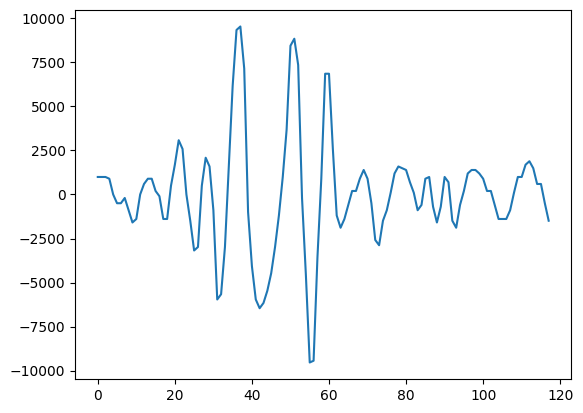

In [90]:
plt.plot(seismic_cube[731,338  ,:])

In [93]:
mean_val, std_val*3

(3.6480365, 5763.069580078125)

In [79]:
mean_val, std_val

(1.1552956, 1746.3317)

In [34]:
seismic_cube.shape

(1526, 933, 325)

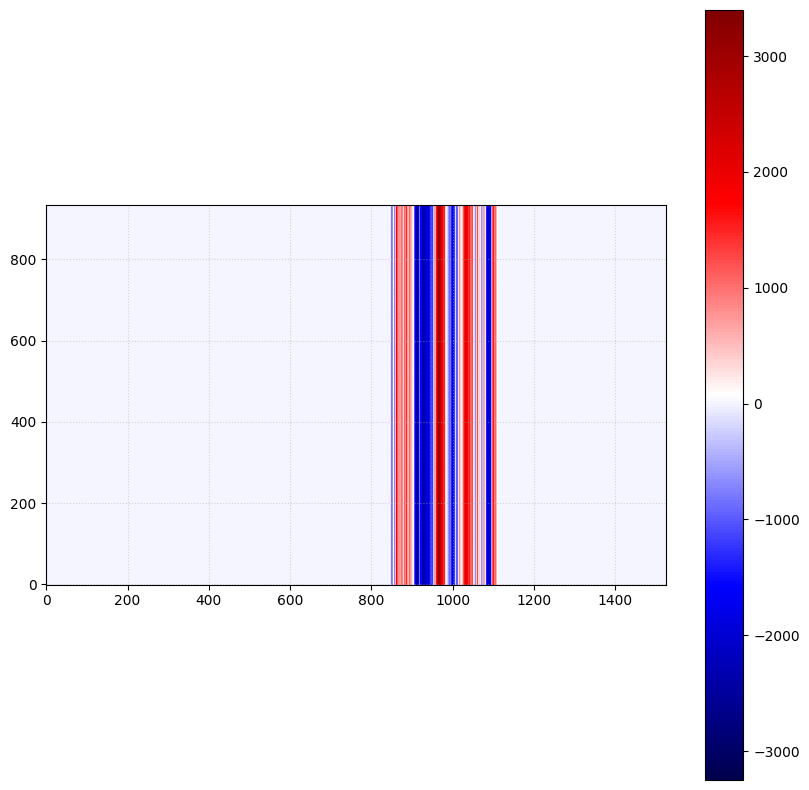

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(xline[:,:,100], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

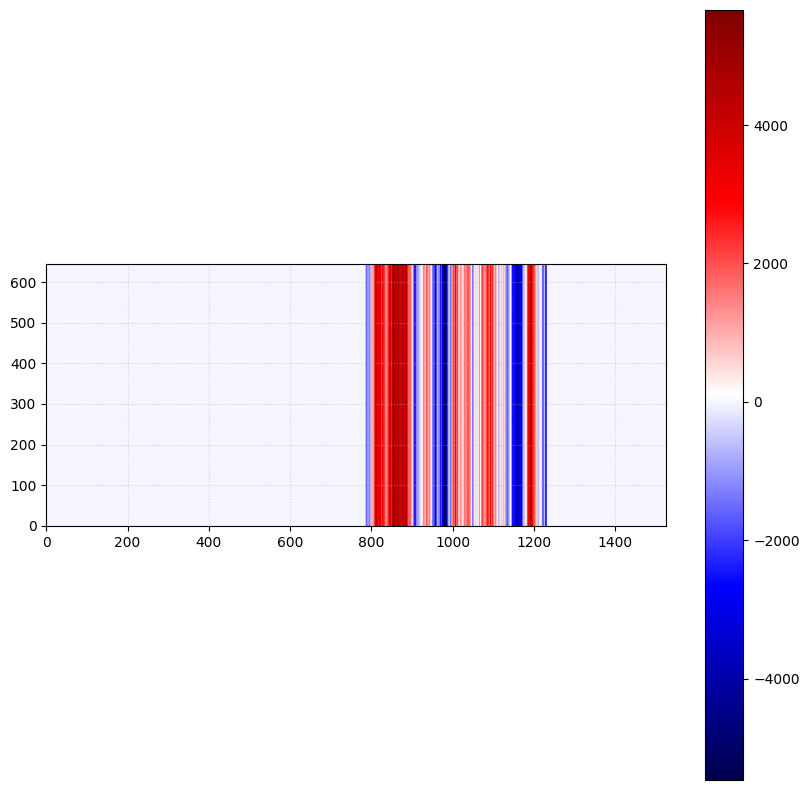

In [28]:
plt.figure(figsize=(10, 10))
plt.imshow(xline[:,:,100], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

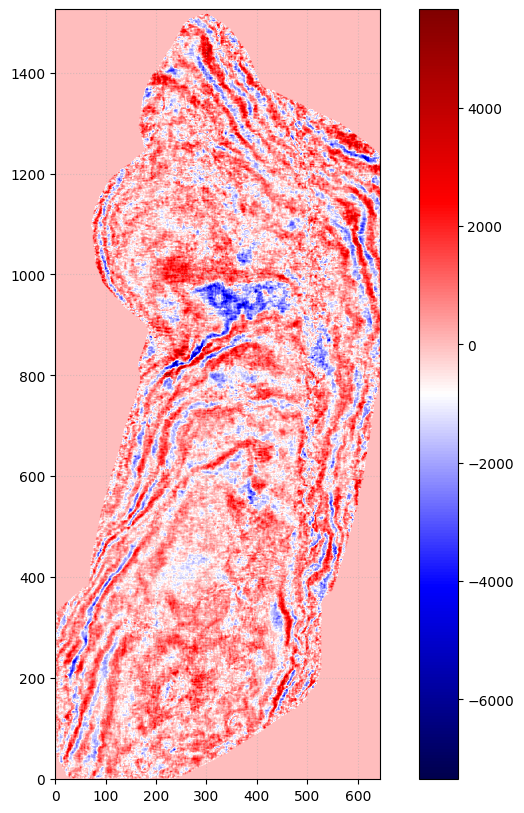

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(seismic_cube[:,:,0], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
segy.samples

In [ ]:
segy.samples

In [ ]:
file_path = 'data/Временной куб NP cropped'

#file_path = 'data/Временной куб NP cropped'

seismic_cube, coordinate_x, coordinate_y, coordinate_z, segy = get_seismic_grid(file_path)


In [ ]:
def test_miss_traces(seismic_cube):
    seismic_cube_ = seismic_cube.reshape(-1, seismic_cube.shape[2])
    mask = np.all(seismic_cube_ ==0 ,axis=1)

    percent_true = (np.sum(mask) / mask.size) * 100
    percent_false = 100 - percent_true



In [ ]:
def visualize_miss_traces(mask, percent_true, percent_false):
    # Подсчет количества пикселей для каждого цвета
    num_true_pixels = np.sum(mask)
    num_false_pixels = np.sum(~mask)
    total_pixels = mask.size

    # Процентное соотношение для каждого цвета
    percent_true = (num_true_pixels / total_pixels) * 100
    percent_false = (num_false_pixels / total_pixels) * 100

    # Определение цветов и соответствующих описаний для легенды
    colors = ['red','blue']
    labels = [f'Сейсмические трассы отсутствуют ({percent_true:.1f}%)',
            f'Сейсмические трассы присутствуют ({percent_false:.1f}%)']

    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='seismic')

    # Создание легенды
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=colors[i], label=labels[i]) for i in range(len(colors))]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.09))

    plt.grid(ls=':', alpha=.5)
    plt.gca().invert_yaxis()
    plt.show()

visualize_miss_traces(mask.reshape((seismic_cube.shape[0], seismic_cube.shape[1])))


In [ ]:
seismic_cube.shape , coordinate_x.shape, coordinate_y.shape, coordinate_z.shape

In [ ]:
file_path = 'data/Глубинный куб NP cropped'

segy = segyio.open(file_path, 'r', strict=False)
seismic_cube_ = segyio.tools.cube(segy)
seismic_cube_.shape

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(seismic_cube_[:,:,0], cmap='seismic')
plt.colorbar()
plt.grid(ls=':', alpha=.5)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
coordinate_x.max(), coordinate_x.min()

In [ ]:
coordinate_x.max(), coordinate_x.min()

In [ ]:
segy.samples

In [ ]:
segy.samples

In [ ]:
segy.xlines

In [ ]:
seismic_cube.shape

In [ ]:
seism_data_qa_qc = QA_QC_seismic(file_path)

In [ ]:
seism_data_qa_qc.license_area_poly = add_noise_to_polygon(build_polygon_from_points(seism_data_qa_qc.coordinate_x, seism_data_qa_qc.coordinate_y), noise_factor=5000)

seism_data_qa_qc.coordinate_validation()

In [ ]:
seism_data_qa_qc.license_area_poly = license_area_poly
seism_data_qa_qc.coordinate_validation()